# Laboratorio 5
Majo Gil 20337

Joshua Chicoj 20566

In [21]:
#imports
import pandas as pd
import re
import string
%pip install nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter
%pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from sklearn.metrics import classification_report

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Majix\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Majix\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [8]:
data = pd.read_csv('data/train.csv')
print(data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## Limpieza y preprocesamiento

In [9]:
# Stopwords
nltk.download('stopwords')

# Definición de las funciones de limpieza
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    # text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

# Aplicamos la limpieza al texto
data['clean_text'] = data['text'].apply(clean_text)
print(data[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Majix\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  got sent photo ruby alaska smoke wildfires pou...  


In [18]:
disaster_tweets = data[data['target'] == 1]['clean_text']
nondisaster_tweets = data[data['target'] == 0]['clean_text']

# Contar las palabras en cada grupo
disaster_words = Counter(" ".join(disaster_tweets).split())
nondisaster_words = Counter(" ".join(nondisaster_tweets).split())

# Palabras más comunes en cada categoría
print("Palabras más comunes en tweets de desastres:", disaster_words.most_common(10))
print("Palabras más comunes en tweets que no son desastres:", nondisaster_words.most_common(10))


Palabras más comunes en tweets de desastres: [('fire', 178), ('news', 135), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 106), ('people', 105), ('killed', 93)]
Palabras más comunes en tweets que no son desastres: [('like', 253), ('im', 243), ('amp', 192), ('new', 168), ('get', 163), ('dont', 141), ('one', 128), ('body', 112), ('via', 99), ('would', 97)]


## Análisis Exploratorio

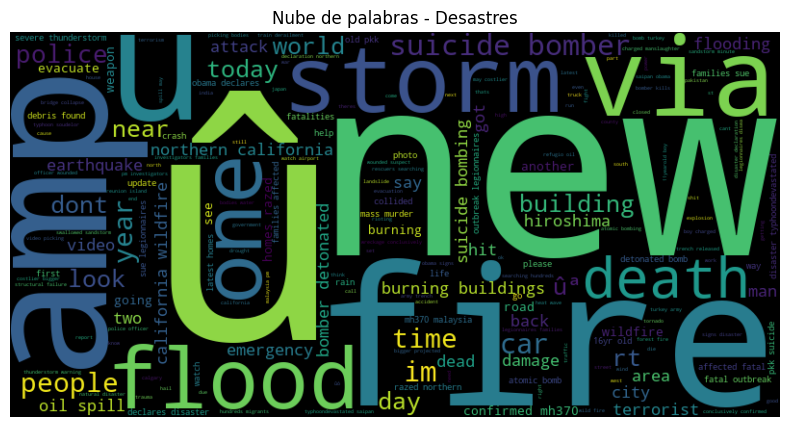

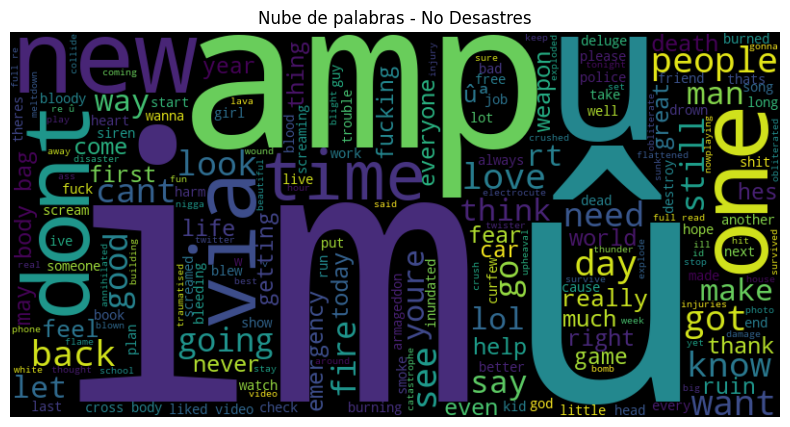

In [19]:
disaster_wordcloud = WordCloud(width=800, height=400).generate(" ".join(disaster_tweets))
plt.figure(figsize=(10, 5))
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Desastres')
plt.show()

# Nube de palabras para tweets que no son desastres
nondisaster_wordcloud = WordCloud(width=800, height=400).generate(" ".join(nondisaster_tweets))
plt.figure(figsize=(10, 5))
plt.imshow(nondisaster_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - No Desastres')
plt.show()


## Modelos LSTM y Random Forest

Epoch 1/5
96/96 - 88s - 913ms/step - accuracy: 0.5670 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/5
96/96 - 86s - 895ms/step - accuracy: 0.5695 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/5
96/96 - 84s - 870ms/step - accuracy: 0.5695 - loss: 0.6847 - val_accuracy: 0.5739 - val_loss: 0.6837
Epoch 4/5
96/96 - 87s - 905ms/step - accuracy: 0.5695 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/5
96/96 - 104s - 1s/step - accuracy: 0.5695 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6826
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step
Confusion Matrix for LSTM:
[[874   0]
 [649   0]]


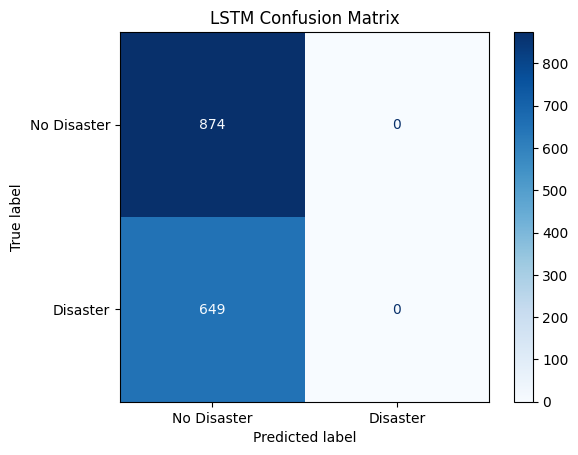

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['clean_text'])

# Convertir texto a secuencias y padding
X_seq = tokenizer.texts_to_sequences(data['clean_text'])
X_padded = pad_sequences(X_seq, maxlen=100, padding='post', truncating='post')
y = data['target'].values

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


max_features = 5000  
model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    SpatialDropout1D(0.25),
    LSTM(100, dropout=0.5, recurrent_dropout=0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Predict and generate confusion matrix
lstm_predictions = model.predict(X_test)
lstm_predictions = (lstm_predictions > 0.5).astype(int)

# Generate confusion matrix for LSTM
lstm_cm = confusion_matrix(y_test, lstm_predictions)
print("Confusion Matrix for LSTM:")
print(lstm_cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=['No Disaster', 'Disaster'])
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix")
plt.show()

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       874
           1       0.76      0.67      0.71       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Confusion Matrix for Random Forest:
[[733 141]
 [213 436]]


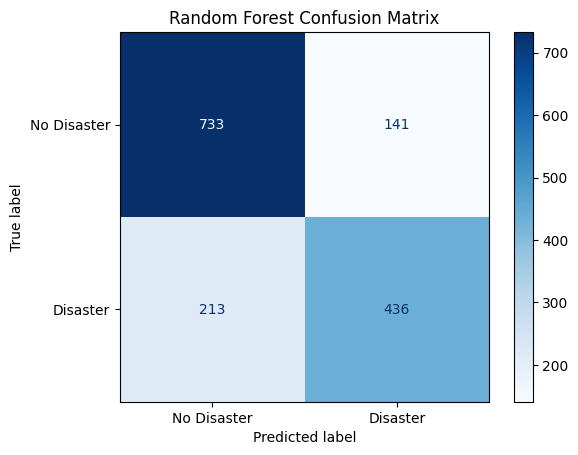

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_rf = vectorizer.fit_transform(data['clean_text']).toarray()

# División en conjuntos de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluación del modelo
rf_predictions = rf_model.predict(X_test_rf)
print("Resultados para Random Forest:")
print(classification_report(y_test_rf, rf_predictions))

rf_predictions = rf_model.predict(X_test_rf)

# Generate confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test_rf, rf_predictions)
print("Confusion Matrix for Random Forest:")
print(rf_cm)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['No Disaster', 'Disaster'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()


## Stemming y eliminación de Acentos

In [28]:
from nltk.stem.porter import PorterStemmer
import unicodedata

# Función para eliminar acentos
def remove_accents(text):
    return ''.join(
        (c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    )

# Modificación de la función de limpieza
def clean_and_stem_text(text):
    text = remove_accents(text)  # Eliminar acentos
    text = clean_text(text)  # Aplicar limpieza previa
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Aplicamos la función de limpieza y stemming
data['stemmed_text'] = data['clean_text'].apply(clean_and_stem_text)


## Volver a correr los modelos

Epoch 1/5
96/96 - 93s - 970ms/step - accuracy: 0.5667 - loss: 0.6859 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 2/5
96/96 - 88s - 916ms/step - accuracy: 0.5695 - loss: 0.6846 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 3/5
96/96 - 84s - 874ms/step - accuracy: 0.5695 - loss: 0.6839 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 4/5
96/96 - 79s - 821ms/step - accuracy: 0.5695 - loss: 0.6834 - val_accuracy: 0.5739 - val_loss: 0.6837
Epoch 5/5
96/96 - 88s - 916ms/step - accuracy: 0.5695 - loss: 0.6842 - val_accuracy: 0.5739 - val_loss: 0.6822
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 400ms/step
Confusion Matrix for LSTM:
[[874   0]
 [649   0]]


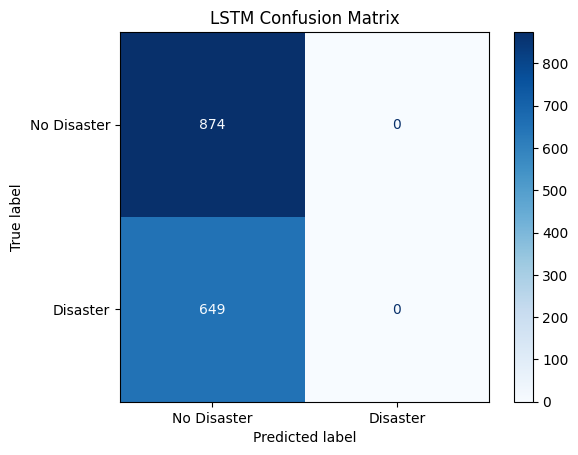

In [29]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['stemmed_text'])

# Convertir texto a secuencias y padding
X_seq = tokenizer.texts_to_sequences(data['stemmed_text'])
X_padded = pad_sequences(X_seq, maxlen=100, padding='post', truncating='post')
y = data['target'].values

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


max_features = 5000  
model = Sequential([
    Embedding(input_dim=5000, output_dim=64),
    SpatialDropout1D(0.25),
    LSTM(100, dropout=0.5, recurrent_dropout=0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Predict and generate confusion matrix
lstm_predictions = model.predict(X_test)
lstm_predictions = (lstm_predictions > 0.5).astype(int)

# Generate confusion matrix for LSTM
lstm_cm = confusion_matrix(y_test, lstm_predictions)
print("Confusion Matrix for LSTM:")
print(lstm_cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=['No Disaster', 'Disaster'])
disp.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix")
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_rf = vectorizer.fit_transform(data['stemmed_text']).toarray()

# División en conjuntos de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluación del modelo
rf_predictions = rf_model.predict(X_test_rf)
print("Resultados para Random Forest:")
print(classification_report(y_test_rf, rf_predictions))

rf_predictions = rf_model.predict(X_test_rf)

# Generate confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test_rf, rf_predictions)
print("Confusion Matrix for Random Forest:")
print(rf_cm)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['No Disaster', 'Disaster'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

## Función de Clasificación

In [ ]:
def classify_tweet_lstm(tweet):
    # Preprocesar el tweet
    clean_tweet = remove_accents(clean_text(tweet))
    seq = tokenizer.texts_to_sequences([clean_tweet])
    padded = pad_sequences(seq, maxlen=100, padding='post', truncating='post')
    # Predecir con LSTM
    prediction = model.predict(padded)
    return 'Desastre' if prediction > 0.5 else 'No Desastre'

def classify_tweet_rf(tweet):
    # Preprocesar el tweet
    clean_tweet = clean_and_stem_text(tweet)
    tweet_vector = vectorizer.transform([clean_tweet]).toarray()
    prediction = rf_model.predict(tweet_vector)
    return 'Desastre' if prediction == 1 else 'No Desastre'

tweet = input("Ingrese un tweet para clasificar con LSTM: ")
print(classify_tweet_lstm(tweet))

tweet = input("Ingrese un tweet para clasificar con Random Forest: ")
print(classify_tweet_rf(tweet))
